The Purpose of this notebook is to provide a kick start for solving Skin Lesion Segmentation problem using Deep learning

I have used 2 architectures
1. UNet architecture (https://arxiv.org/abs/1505.04597) 
2. Segnet architecture (https://arxiv.org/pdf/1511.00561.pdf)

At a high level below are the steps followed

1. Create a Dataloader. For creating a data loader we have rescaled the images into (256 x 256) format. As images are in grayscale format no other augmentation is done. However based on research done by us, augmenting the images (specifically rotation ) can help in getting more accuracy
2. Create a UNet archiecture
3. Create Dice Loss
4. Train the model
5. Evaluate the model for few images to check basic convergence. 

In [68]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as tfms
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy as sc
import os
import PIL
import cv2
import PIL.Image as Image
import seaborn as sns
%matplotlib inline

In [41]:
TRAIN_PATH = r'D:\Work\DL_learn\Datasets\SkinCancer\Images'
bs = 2
num_epochs = 1000
learning_rate = 1e-2
mom  = 0.9

In [42]:
class SkinLesionDataLoader(data.Dataset):
    def __init__(self,root_dir,seg_dir,transforms = None):
        self.root_dir = root_dir
        self.seg_dir = seg_dir
        self.transforms = transforms
        self.files = os.listdir(self.root_dir)
        self.lables = os.listdir(self.seg_dir)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        img_name = self.files[idx]
        label_name = self.lables[idx]
        img = Image.open(os.path.join(self.root_dir,img_name))
        label = Image.open(os.path.join(self.seg_dir,label_name))
        if self.transforms:
            img = self.transforms(img)
            label = self.transforms(label)
            return img,label
        else:
            return img, label

In [43]:
train_dataset = SkinLesionDataLoader(r'D:\Work\DL_learn\Datasets\SkinCancer\Images',
                                     r'D:\Work\DL_learn\Datasets\SkinCancer\Segmentations',
                                    transforms=tfms.Compose([tfms.Resize((256,256)),tfms.ToTensor()
                                                            ]))

In [44]:
train_loader = data.DataLoader(train_dataset,shuffle=False,batch_size=bs)

In [45]:
# Test correctness of dataloader
test_img, test_lb = next(iter(train_loader))

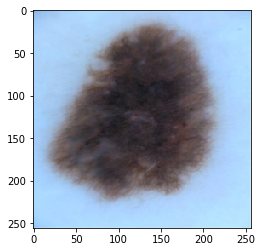

In [7]:
plt.imshow(test_img[0].permute(2,1,0))

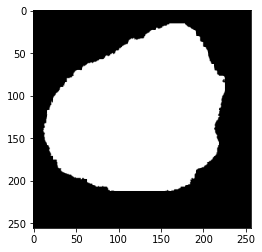

In [8]:
plt.imshow(test_lb[0].squeeze(),cmap = 'gray')

In [2]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()

        self.encoder_1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True)
        )  # first group

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 64, 7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True)
        )  # second group

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(64, 64, 7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True)
        )  # third group

        self.encoder_4 = nn.Sequential(
            nn.Conv2d(64, 64, 7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True)
        )  # fourth group

        self.unpool_1 = nn.MaxUnpool2d(2, stride=2)  # get masks
        self.unpool_2 = nn.MaxUnpool2d(2, stride=2)
        self.unpool_3 = nn.MaxUnpool2d(2, stride=2)
        self.unpool_4 = nn.MaxUnpool2d(2, stride=2)

        self.decoder_1 = nn.Sequential(
            nn.Conv2d(64, 64, 7, padding=3),
            nn.BatchNorm2d(64)
        )  # first group

        self.decoder_2 = nn.Sequential(
            nn.Conv2d(64, 64, 7, padding=3),
            nn.BatchNorm2d(64)
        )  # second group

        self.decoder_3 = nn.Sequential(
            nn.Conv2d(64, 64, 7, padding=3),
            nn.BatchNorm2d(64)
        )  # third group

        self.decoder_4 = nn.Sequential(
            nn.Conv2d(64, 1, 7, padding=3),
            nn.BatchNorm2d(1)
        )  # fourth group
   
    def weight_init(self):
        for i,m in enumerate(self.modules()):
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_normal(m.weight)
                nn.init.constant(m.bias, 0)

    def forward(self, x):
        size_1 = x.size()
        x, indices_1 = self.encoder_1(x)

        size_2 = x.size()
        x, indices_2 = self.encoder_2(x)

        size_3 = x.size()
        x, indices_3 = self.encoder_3(x)

        size_4 = x.size()
        x, indices_4 = self.encoder_4(x)

        x = self.unpool_1(x, indices_4, output_size=size_4)
        x = self.decoder_1(x)

        x = self.unpool_2(x, indices_3, output_size=size_3)
        x = self.decoder_2(x)

        x = self.unpool_3(x, indices_2, output_size=size_2)
        x = self.decoder_3(x)

        x = self.unpool_4(x, indices_1, output_size=size_1)
        x = self.decoder_4(x)

        x = F.sigmoid(x)

        return x

In [7]:
model  = SegNet().cuda()
model.weight_init()

C:\Users\mohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
C:\Users\mohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [ ]:
test_res  = model(test_img)

In [ ]:
test_res.shape

In [8]:
class DiceCoeffLoss(nn.Module):
    def __init__(self,smooth=1):
        super(DiceCoeffLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self,input, target):
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + self.smooth) / (iflat.sum() + tflat.sum() + self.smooth))

In [9]:
criterion = DiceCoeffLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-5,momentum=mom)

In [12]:
test_op = model(test_img.cuda())
criterion.forward(test_lb.cuda(),test_op)

tensor(0.6494, device='cuda:0')

In [14]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs')

In [16]:
niter = 0
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images = images.cuda()
        labels =labels.cuda()
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion.forward(labels,outputs)
        loss.backward()
        optimizer.step()
        del images,labels,outputs
        if i%100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss = %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//bs, loss.data))
            writer.add_scalar('Train/Loss', loss.data, niter)
            niter+=100

Epoch [1/1000], Step [1/500], Loss = 0.6493
Epoch [1/1000], Step [101/500], Loss = 0.6777
Epoch [1/1000], Step [201/500], Loss = 0.2787
Epoch [1/1000], Step [301/500], Loss = 0.9637
Epoch [1/1000], Step [401/500], Loss = 0.9218
Epoch [2/1000], Step [1/500], Loss = 0.3690
Epoch [2/1000], Step [101/500], Loss = 0.2787
Epoch [2/1000], Step [201/500], Loss = 0.3300
Epoch [2/1000], Step [301/500], Loss = 0.9359
Epoch [2/1000], Step [401/500], Loss = 0.8139
Epoch [3/1000], Step [1/500], Loss = 0.2860
Epoch [3/1000], Step [101/500], Loss = 0.1240
Epoch [3/1000], Step [201/500], Loss = 0.3850
Epoch [3/1000], Step [301/500], Loss = 0.9190
Epoch [3/1000], Step [401/500], Loss = 0.6799
Epoch [4/1000], Step [1/500], Loss = 0.4075
Epoch [4/1000], Step [101/500], Loss = 0.0920
Epoch [4/1000], Step [201/500], Loss = 0.4446
Epoch [4/1000], Step [301/500], Loss = 0.8794
Epoch [4/1000], Step [401/500], Loss = 0.5796
Epoch [5/1000], Step [1/500], Loss = 0.4751
Epoch [5/1000], Step [101/500], Loss = 0.086

KeyboardInterrupt: 

In [17]:
#saving model
torch.save(model.state_dict(),'SegNetBasic_60e_SiknLesion.pth')

In [3]:
#load model
model  = SegNet().cuda()
model.load_state_dict(torch.load('SegNetBasic_60e_SiknLesion.pth'))

In [5]:
# Testing some Basic Traning Predictions
transforms=tfms.Compose([
    tfms.Resize((256,256)),
    tfms.ToTensor()
])
img_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Images/ISIC_0000001.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Segmentations/ISIC_0000001_expert.png")
lb_test = transforms(lb_test)

In [6]:
# Helper function to display image
def display_prediction(img,true_label):
    seg_pred = model(img_test.unsqueeze(0).cuda())
    fig,axes = plt.subplots(nrows = 1,ncols=3,figsize = (10,10))
    axes[0].imshow(img.permute(1,2,0))
    axes[0].set_title('Image')
    axes[1].imshow(seg_pred[0].squeeze().detach(),cmap = 'gray')
    axes[1].set_title('Prediction')
    axes[2].imshow(true_label.squeeze(),cmap = 'gray')
    axes[2].set_title('Ground Truth')

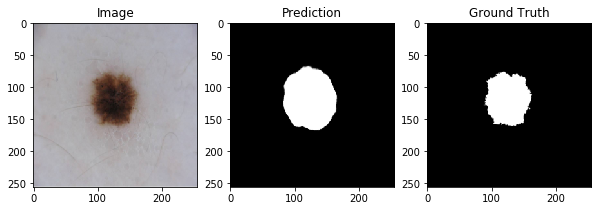

In [7]:
display_prediction(img_test,lb_test)

In [55]:
img_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Images/ISIC_0000557.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Segmentations/ISIC_0000557_expert.png")
lb_test = transforms(lb_test)

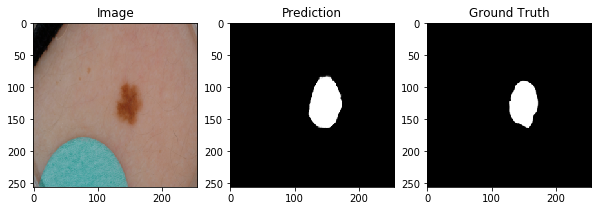

In [58]:
display_prediction(img_test,lb_test)

In [61]:
img_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Images/ISIC_0000042.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Segmentations/ISIC_0000042_expert.png")
lb_test = transforms(lb_test)

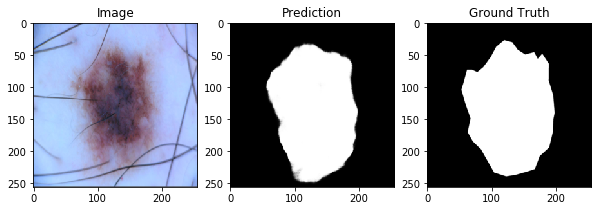

In [62]:
display_prediction(img_test,lb_test)

In [8]:
from skimage.morphology import label as sk_label
from scipy.ndimage.filters import gaussian_filter

In [60]:
# Code adopted from https://github.com/yuanqing811/ISIC2018/blob/master/runs/seg_eval.py
def task1_post_process(y_prediction, threshold=0.5, gauss_sigma=0.):
    for im_index in range(y_prediction.shape[0]):
        # smooth image by Gaussian filtering
        if gauss_sigma > 0.:
            y_prediction[im_index] = gaussian_filter(input=y_prediction[im_index], sigma=gauss_sigma)
        thresholded_image = y_prediction[im_index] > threshold
        # find largest connected component
        #print(thresholded_image.shape)
        labels, num_labels = sk_label(thresholded_image, return_num=True)
        max_label_idx = -1
        max_size = 0
        for label_idx in range(0, num_labels + 1):
            if np.sum(thresholded_image[labels == label_idx]) == 0:
                continue
            current_size = np.sum(labels == label_idx)
            if current_size > max_size:
                max_size = current_size
                max_label_idx = label_idx
        if max_label_idx > -1:
            y_prediction[im_index] = labels == max_label_idx
        else: # no predicted pixels found
            y_prediction[im_index] = y_prediction[im_index] * 0
    return y_prediction

In [35]:
def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

In [24]:
#Testing functions
y_test = model(img_test.unsqueeze(0).cuda())
y_test_post = task1_post_process(y_test.detach().cpu().numpy())

In [40]:
mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=lb_test.numpy(), y_pred=y_test_post.squeeze(1))
print('Mean jaccard = %.3f, Thresholded Jaccard = %.3f ' % (mean_jaccard, thresholded_jaccard))

Mean jaccard = 0.722, Thresholded Jaccard = 0.722 


In [62]:
avg_mean_jaccard = []

In [63]:
for i,(images,labels) in enumerate(train_loader):
        print('Generating Stats for Batch - ' + str(i))
        images = images.cuda()
        y_pred = model(images)
        y_pred_post = task1_post_process(y_pred.detach().cpu().numpy())
        mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=labels.numpy(), y_pred=y_pred_post.squeeze(1))
        avg_mean_jaccard.append(mean_jaccard)
        print('Mean jaccard = %.3f, Thresholded Jaccard = %.3f ' % (mean_jaccard, thresholded_jaccard))

Generating Stats for Batch - 0
Mean jaccard = 0.890, Thresholded Jaccard = 0.890 
Generating Stats for Batch - 1
Mean jaccard = 0.929, Thresholded Jaccard = 0.929 
Generating Stats for Batch - 2
Mean jaccard = 0.885, Thresholded Jaccard = 0.885 
Generating Stats for Batch - 3
Mean jaccard = 0.854, Thresholded Jaccard = 0.854 
Generating Stats for Batch - 4
Mean jaccard = 0.921, Thresholded Jaccard = 0.921 
Generating Stats for Batch - 5
Mean jaccard = 0.897, Thresholded Jaccard = 0.897 
Generating Stats for Batch - 6
Mean jaccard = 0.863, Thresholded Jaccard = 0.863 
Generating Stats for Batch - 7
Mean jaccard = 0.888, Thresholded Jaccard = 0.888 
Generating Stats for Batch - 8
Mean jaccard = 0.902, Thresholded Jaccard = 0.902 
Generating Stats for Batch - 9
Mean jaccard = 0.910, Thresholded Jaccard = 0.910 
Generating Stats for Batch - 10
Mean jaccard = 0.889, Thresholded Jaccard = 0.889 
Generating Stats for Batch - 11
Mean jaccard = 0.915, Thresholded Jaccard = 0.915 
Generating Sta

Mean jaccard = 0.928, Thresholded Jaccard = 0.928 
Generating Stats for Batch - 99
Mean jaccard = 0.852, Thresholded Jaccard = 0.852 
Generating Stats for Batch - 100
Mean jaccard = 0.888, Thresholded Jaccard = 0.888 
Generating Stats for Batch - 101
Mean jaccard = 0.538, Thresholded Jaccard = 0.359 
Generating Stats for Batch - 102
Mean jaccard = 0.872, Thresholded Jaccard = 0.872 
Generating Stats for Batch - 103
Mean jaccard = 0.894, Thresholded Jaccard = 0.894 
Generating Stats for Batch - 104
Mean jaccard = 0.815, Thresholded Jaccard = 0.815 
Generating Stats for Batch - 105
Mean jaccard = 0.944, Thresholded Jaccard = 0.944 
Generating Stats for Batch - 106
Mean jaccard = 0.920, Thresholded Jaccard = 0.920 
Generating Stats for Batch - 107
Mean jaccard = 0.850, Thresholded Jaccard = 0.850 
Generating Stats for Batch - 108
Mean jaccard = 0.941, Thresholded Jaccard = 0.941 
Generating Stats for Batch - 109
Mean jaccard = 0.897, Thresholded Jaccard = 0.897 
Generating Stats for Batch

Mean jaccard = 0.855, Thresholded Jaccard = 0.855 
Generating Stats for Batch - 196
Mean jaccard = 0.821, Thresholded Jaccard = 0.821 
Generating Stats for Batch - 197
Mean jaccard = 0.721, Thresholded Jaccard = 0.721 
Generating Stats for Batch - 198
Mean jaccard = 0.880, Thresholded Jaccard = 0.880 
Generating Stats for Batch - 199
Mean jaccard = 0.660, Thresholded Jaccard = 0.390 
Generating Stats for Batch - 200
Mean jaccard = 0.441, Thresholded Jaccard = 0.390 
Generating Stats for Batch - 201
Mean jaccard = 0.860, Thresholded Jaccard = 0.860 
Generating Stats for Batch - 202
Mean jaccard = 0.570, Thresholded Jaccard = 0.452 
Generating Stats for Batch - 203
Mean jaccard = 0.870, Thresholded Jaccard = 0.870 
Generating Stats for Batch - 204
Mean jaccard = 0.930, Thresholded Jaccard = 0.930 
Generating Stats for Batch - 205
Mean jaccard = 0.863, Thresholded Jaccard = 0.863 
Generating Stats for Batch - 206
Mean jaccard = 0.833, Thresholded Jaccard = 0.833 
Generating Stats for Batc

Mean jaccard = 0.809, Thresholded Jaccard = 0.809 
Generating Stats for Batch - 293
Mean jaccard = 0.861, Thresholded Jaccard = 0.861 
Generating Stats for Batch - 294
Mean jaccard = 0.812, Thresholded Jaccard = 0.812 
Generating Stats for Batch - 295
Mean jaccard = 0.712, Thresholded Jaccard = 0.394 
Generating Stats for Batch - 296
Mean jaccard = 0.661, Thresholded Jaccard = 0.404 
Generating Stats for Batch - 297
Mean jaccard = 0.619, Thresholded Jaccard = 0.406 
Generating Stats for Batch - 298
Mean jaccard = 0.819, Thresholded Jaccard = 0.819 
Generating Stats for Batch - 299
Mean jaccard = 0.872, Thresholded Jaccard = 0.872 
Generating Stats for Batch - 300
Mean jaccard = 0.741, Thresholded Jaccard = 0.741 
Generating Stats for Batch - 301
Mean jaccard = 0.736, Thresholded Jaccard = 0.736 
Generating Stats for Batch - 302
Mean jaccard = 0.305, Thresholded Jaccard = 0.000 
Generating Stats for Batch - 303
Mean jaccard = 0.728, Thresholded Jaccard = 0.403 
Generating Stats for Batc

Mean jaccard = 0.876, Thresholded Jaccard = 0.876 
Generating Stats for Batch - 390
Mean jaccard = 0.773, Thresholded Jaccard = 0.773 
Generating Stats for Batch - 391
Mean jaccard = 0.796, Thresholded Jaccard = 0.796 
Generating Stats for Batch - 392
Mean jaccard = 0.687, Thresholded Jaccard = 0.401 
Generating Stats for Batch - 393
Mean jaccard = 0.835, Thresholded Jaccard = 0.835 
Generating Stats for Batch - 394
Mean jaccard = 0.827, Thresholded Jaccard = 0.827 
Generating Stats for Batch - 395
Mean jaccard = 0.796, Thresholded Jaccard = 0.796 
Generating Stats for Batch - 396
Mean jaccard = 0.703, Thresholded Jaccard = 0.703 
Generating Stats for Batch - 397
Mean jaccard = 0.353, Thresholded Jaccard = 0.353 
Generating Stats for Batch - 398
Mean jaccard = 0.871, Thresholded Jaccard = 0.871 
Generating Stats for Batch - 399
Mean jaccard = 0.844, Thresholded Jaccard = 0.844 
Generating Stats for Batch - 400
Mean jaccard = 0.778, Thresholded Jaccard = 0.778 
Generating Stats for Batc

Mean jaccard = 0.728, Thresholded Jaccard = 0.728 
Generating Stats for Batch - 487
Mean jaccard = 0.751, Thresholded Jaccard = 0.751 
Generating Stats for Batch - 488
Mean jaccard = 0.551, Thresholded Jaccard = 0.352 
Generating Stats for Batch - 489
Mean jaccard = 0.700, Thresholded Jaccard = 0.426 
Generating Stats for Batch - 490
Mean jaccard = 0.769, Thresholded Jaccard = 0.454 
Generating Stats for Batch - 491
Mean jaccard = 0.789, Thresholded Jaccard = 0.789 
Generating Stats for Batch - 492
Mean jaccard = 0.710, Thresholded Jaccard = 0.710 
Generating Stats for Batch - 493
Mean jaccard = 0.751, Thresholded Jaccard = 0.751 
Generating Stats for Batch - 494
Mean jaccard = 0.749, Thresholded Jaccard = 0.749 
Generating Stats for Batch - 495
Mean jaccard = 0.114, Thresholded Jaccard = 0.000 
Generating Stats for Batch - 496
Mean jaccard = 0.766, Thresholded Jaccard = 0.766 
Generating Stats for Batch - 497
Mean jaccard = 0.674, Thresholded Jaccard = 0.364 
Generating Stats for Batc

In [67]:
print('The Mean training Jaccard Index is = %.3f' % (np.mean(avg_mean_jaccard)))

The Mean training Jaccard Index is = 0.808


C:\Users\mohit\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


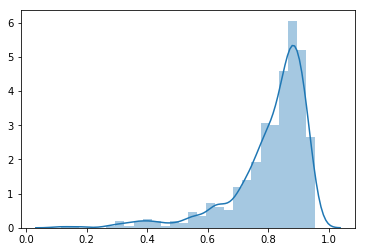

In [69]:
sns.distplot(pd.Series(avg_mean_jaccard))

In [70]:
val_dataset = SkinLesionDataLoader(r'D:/Work/DL_learn/Datasets/SkinCancer/Images_valid/',
                                     r'D:/Work/DL_learn/Datasets/SkinCancer/Segmentations_valid/',
                                    transforms=tfms.Compose([tfms.Resize((256,256)),tfms.ToTensor()
                                                            ]))

In [71]:
val_loader = data.DataLoader(val_dataset,shuffle=False,batch_size=bs)

In [72]:
avg_mean_jaccard = []

In [73]:
for i,(images,labels) in enumerate(val_loader):
        print('Generating Stats for Batch - ' + str(i))
        images = images.cuda()
        y_pred = model(images)
        y_pred_post = task1_post_process(y_pred.detach().cpu().numpy())
        mean_jaccard, thresholded_jaccard = compute_jaccard(y_true=labels.numpy(), y_pred=y_pred_post.squeeze(1))
        avg_mean_jaccard.append(mean_jaccard)
        print('Mean jaccard = %.3f, Thresholded Jaccard = %.3f ' % (mean_jaccard, thresholded_jaccard))

Generating Stats for Batch - 0
Mean jaccard = 0.446, Thresholded Jaccard = 0.446 
Generating Stats for Batch - 1
Mean jaccard = 0.737, Thresholded Jaccard = 0.737 
Generating Stats for Batch - 2
Mean jaccard = 0.541, Thresholded Jaccard = 0.349 
Generating Stats for Batch - 3
Mean jaccard = 0.748, Thresholded Jaccard = 0.455 
Generating Stats for Batch - 4
Mean jaccard = 0.654, Thresholded Jaccard = 0.409 
Generating Stats for Batch - 5
Mean jaccard = 0.330, Thresholded Jaccard = 0.000 
Generating Stats for Batch - 6
Mean jaccard = 0.137, Thresholded Jaccard = 0.000 
Generating Stats for Batch - 7
Mean jaccard = 0.584, Thresholded Jaccard = 0.357 
Generating Stats for Batch - 8
Mean jaccard = 0.393, Thresholded Jaccard = 0.393 
Generating Stats for Batch - 9
Mean jaccard = 0.750, Thresholded Jaccard = 0.750 
Generating Stats for Batch - 10
Mean jaccard = 0.563, Thresholded Jaccard = 0.398 
Generating Stats for Batch - 11
Mean jaccard = 0.671, Thresholded Jaccard = 0.383 
Generating Sta

The Mean training Jaccard Index is = 0.587


C:\Users\mohit\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


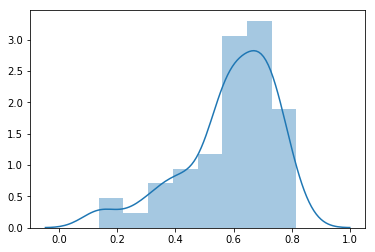

In [74]:
print('The Mean training Jaccard Index is = %.3f' % (np.mean(avg_mean_jaccard)))
sns.distplot(pd.Series(avg_mean_jaccard))

In [77]:
img_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Images_valid/ISIC_0001057.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Segmentations_valid/ISIC_0001057_expert.png")
lb_test = transforms(lb_test)

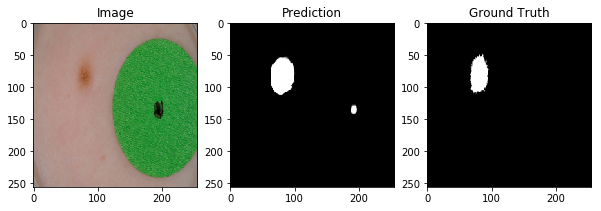

In [78]:
display_prediction(img_test,lb_test)

In [79]:
img_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Images_valid/ISIC_0001099.jpg")
img_test  = transforms(img_test)           
lb_test = Image.open(r"D:/Work/DL_learn/Datasets/SkinCancer/Segmentations_valid/ISIC_0001099_expert.png")
lb_test = transforms(lb_test)

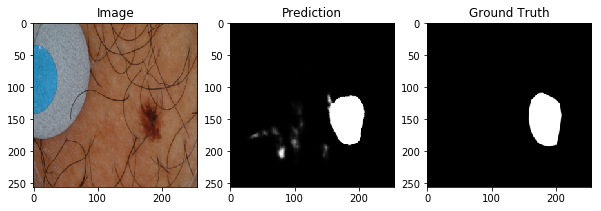

In [80]:
display_prediction(img_test,lb_test)